In [121]:
import pytesseract
from pytesseract import Output
import re
import glob
#from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

## Função que lê imagens, aplica image_to_data e retorna as keys

In [122]:
def data_keys(img):
    d = pytesseract.image_to_data(img, output_type=Output.DICT)
    return d

## Função para extrair datas

In [135]:
def get_datas(img, d):
    date_pattern = '^(0[1-9]|[12][0-9]|3[01])/(0[1-9]|1[012])/(19|20)\d\d$' # expressão regular para datas
    data_nasc, data_val, data_ph = 0, 0, 0
    n_boxes = len(d['text'])
    for i in range(n_boxes):
        if int(d['conf'][i]) > 40:
            print(d['text'][i])
            if re.match(date_pattern, d['text'][i]):
                #print(d['text'][i])
                (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
                img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
                if int(d['top'][i]) >= 150 and int(d['top'][i]) <= 250:
                    data_nasc = d['text'][i]
                elif int(d['left'][i]) >= 290 and int(d['left'][i]) <= 400:
                    data_val = d['text'][i]
                elif int(d['left'][i]) >= 400 and int(d['left'][i]) <= 600:
                    data_ph = d['text'][i]
    plt.imshow(img)
    plt.show()
    
    return data_nasc, data_val, data_ph

## Função para extrair CPF

In [124]:
def get_cpf(img, d):
    cpf_pattern = '[0-9]{3}\.?[0-9]{3}\.?[0-9]{3}\-?[0-9]{2}'

    #cpf_expr = re.compile('\d{3}\.\d{3}\.\d{3}\-\d{2}')
    #cpf_expr1 = re.compile('\d{3}\.\d{3}')
    #cpf_expr2 = re.compile('\d{3}\?\d{2}')                     

    cpf = 0
    
    n_boxes = len(d['text'])
    for i in range(n_boxes):
        if int(d['conf'][i]) > 40:
            if re.match(cpf_pattern, d['text'][i]):
                print(d['text'][i])
                (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
                img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cpf = d['text'][i]

    plt.imshow(img)
    plt.show()
    
    return cpf

In [125]:
"""
img = cv2.imread('../processada.jpg')
#print(img.shape)
d = data_keys(img)
"""

"\nimg = cv2.imread('../processada.jpg')\n#print(img.shape)\nd = data_keys(img)\n"

In [126]:
"""
data_nasc, data_val, data_ph = get_datas(img, d)
print("Data de nascimento: ", data_nasc)
print("Data de validade: ", data_val)
print("Data da 1° habilitação: ", data_ph)
"""

'\ndata_nasc, data_val, data_ph = get_datas(img, d)\nprint("Data de nascimento: ", data_nasc)\nprint("Data de validade: ", data_val)\nprint("Data da 1° habilitação: ", data_ph)\n'

vAuDA
EM
mm)
o
Tmmdmo
NACIONAL
  
mm:
"
DIEGO
DE.
oLxVEmA
PAIVA
  
 
  
    
   
  
 
 
—wcmeunmulonelwmww
3735035
5535
an
-0;
wmmmo
v
96d-42
I31/05/1995.
-mACID
cross
ANTONIO
PAM
SILVA
Rosmssu
SALES
DE
OLIVEIRR
 
 
 
"‘"m‘
‘ufﬁfwb
 
 
 
 
 
 
 
I.
mun
M.
 



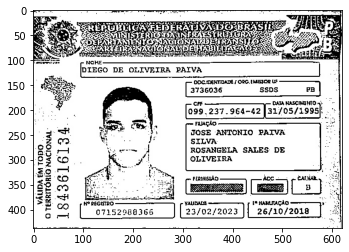

Data de nascimento:  0
Data de validade:  0
Data da 1° habilitação:  0
 
EAMELA
DE
OLIVEIEA
SMAIO
 
  
VALIDA
EM
TODD
0&me
:
z
9
g
z
2
S
0
E
E
..
0
C)
l!)
CD
<9
G?
<H
Ln
<14
00
,_[
4258795
—nocmnwalmmnsnnu;
 
mum
—w
094.267
334—42
11/03/2000
 
_nww
CARVALHO
 
PEDRO
mam
D8
MARIA
DA
CQNCEICAD
OLIVEIRA
CARVALHO
 
—'
mm
pmssﬁo
 
 
rm[
:3
 
m
mm);
_
07429160429
04/03/2021
 
 
rs
mun
04/03/2020


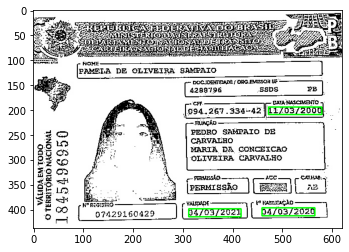

Data de nascimento:  11/03/2000
Data de validade:  04/03/2021
Data da 1° habilitação:  04/03/2020
  
0
DE
MDRADE
LEAD
TEIXEIRA
 
 
 
Doc.
missunl
w
§u252757
5511/5?
m
mrnursanmm-
,,
450
.
809'.
605—29
17/09/2000
muck:
ADEMI'R
LEAK)
TEIXEIRA
 
     
  
KILDA
WCELA
DE
AND“
DE
BERG
TEIXEIRA
nswssln
Mz'
anus,—
PERMISSAO
a_-
a
wunmi
:I
mmtmua
—.
 
mmxsmo
07323860470
vAunA
EM
mm:
(13
gm
9w
u
<14
51.x
:0)
gal
EO
go:
or!
 
 
04/09/2020
M
06/09/2019
J
 
 
 
 
  
   



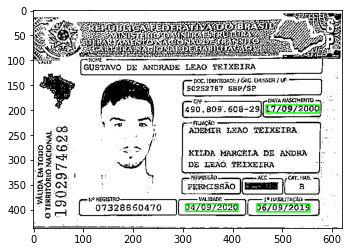

Data de nascimento:  17/09/2000
Data de validade:  04/09/2020
Data da 1° habilitação:  06/09/2019
  
mum}:
EM
man
u
Tinnnnmn
Nnnlnml
mwmm
um
 
 
NaﬁE
'
‘
H
'
.
GABRIELA
Rocmx
LUCENA
LDPES
.
 
 
-
nocJuanlel
exummu
ur
3439404
asp
ma
    
 
 
 
 
—ch-————
mlANAichmm
--
091.527.0744:
09/11/1991
,
Ammo
FERNANDO
ANTONIO
FERREIRA
LDPES
MARIA
HELENA
ROEHA
LUCENA
LOPES
L—_'_—
_nnM|ssAa
ACC
[mm
.
l
a
 
 
 
 
 
 
 
  
 
 
 
 
 
 
 
WIEGLHRO
f
05173323518
 
 
mum»
31/03/2011
 
VAunwE
02/06/2021
f
 
 



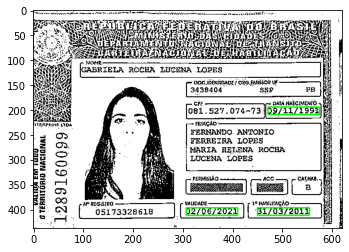

Data de nascimento:  09/11/1991
Data de validade:  02/06/2021
Data da 1° habilitação:  31/03/2011
  
 
 
1r
K?
m
"m_—
DANIELE
LACEﬁDA
DE
ARAUJO
 
 
vAnnA
EM
room
w
mums
845502881
r—W
55321297
3
2
2
u
<
z
’9
a:
E
E
5
..
o
 
—
nocmsmmqu
nmww
ur
361331!)
,
sst
 
 
 
-9;
_mANAsaMENlo
 
r—
muck:
ammo
mcimnA
FRANCISCA
RODRIGUES
DE:
mum
LACERDA
 
  
 
 
 
m:
min;
[3,
 
 
 
 
094.554.154319
31/0311990
 
   
 
 
mum:
I-Imnwo
'
06/03/2025
13/05/2015
 



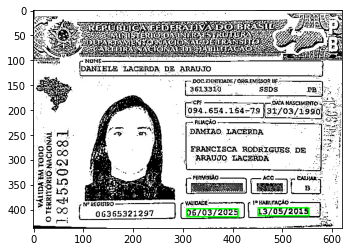

Data de nascimento:  0
Data de validade:  06/03/2025
Data da 1° habilitação:  13/05/2015
  
vAuDA
EM
moo
o
Tmmdmo
mcmmu
j1843616134
mm;
"
DIEGO
DE
DLIVEIM
PAIVA
  
  
 
 
  
—oocwmmmrommw
3735036
5535
as
mummmo
r
399.
237.
95d-
42'31/05/1995’.
_m;;D—_—
aoss
ANTONIO
PAIVA
SILVA
RDSMEELA
SALES
DE
OLIVEIRR
m
If
”Ll
w-
moo"
mm
I-mluucln
07152900366
23/02/2023
26/10/2018
 
   
 
    
    
 
 
..
p(mmn
 
 
  
 
 
 
 
 
 
 
 



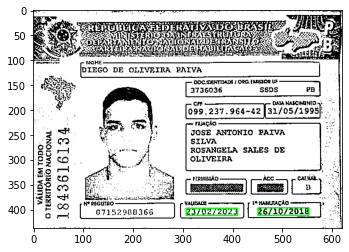

Data de nascimento:  0
Data de validade:  23/02/2023
Data da 1° habilitação:  26/10/2018
 
vAuo‘A
EM
YOU!)
2
2
z
D
E
L:
E
.-
a
O
to
(N
C
00
LG
00
(*3
00
H
 
Nuns
cmos
ANDRE
(:1le
DE
Mam
 
zean457
.Inmnmi
I
onemusnu
us
55?
PE
'
 
-cn
mummmma
:
073.982,684-05
”12/09/1988‘
 
_
mucAo
MELO
 
 
museum:
mm:
u-mmao
0398359l705
28/05/2024
06/12/2006
 
  
  
 
 
 
ANTONIO
CARLOS
FERREIRA
Dz
MELO
ANDREA
mm
CIRNE
DE
 
 
 
m:
mm
W
B



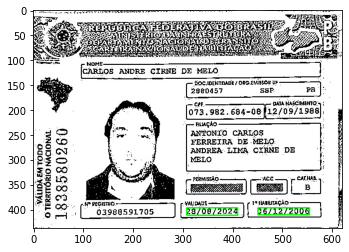

Data de nascimento:  0
Data de validade:  28/05/2024
Data da 1° habilitação:  06/12/2006


In [136]:
imgs = glob.glob("../alinhadas/*jpg")

for c in imgs:
    img = cv2.imread(c)
    d = data_keys(img)
    data_nasc, data_val, data_ph = get_datas(img, d)
    print("Data de nascimento: ", data_nasc)
    print("Data de validade: ", data_val)
    print("Data da 1° habilitação: ", data_ph)

In [128]:
#cpf = get_cpf(img, d)
#print("CPF: ", cpf)

Próximos passos:

- melhorar segmentação das imagens, a leitura está péssima

- conseguir validar o cpf
https://community.alteryx.com/t5/Casos-de-uso-Portugues/Validacao-de-CPF-com-digito-verificador/ta-p/437296

OBS.: o regex cpf_pattern está reconhecendo o número de registro e não o cpf